# Creating MOM6 Grid Files from a pre-existing Grid

MOM6 needs the following INPUT files for a given run (all netcdf3):

- Ocean Horizontal Grid
- Ocean Topography/Bathymetry (with depth variable)
- Ocean Mask
- Land Mask
- Ocean Mosaic
- Land Mosaic
- Land x Ocean Mosaic
- Atmos x Land Mosaic
- Atmos x Ocean Mosaic
- Rivers File
- Ocean Vertical Grid
- grid_spec.nc (this file contains information regarding the directory locations and names of the mosaic files - this file MUST be netcdf3, just like all of the others)

In this example, we will create ocean horizontal grid + bathymetry files from larger, pre-made ocean horizontal grid + bathymetry files. These files will be used as inputs for ESMG Gridtools functions that generate Ocean/Land Mask + mosaic files. We don't need to edit Ocean Vertical Grids for this. As long as naming conventions are the same, we won't need to edit the pre-given grid_spec.nc file either. At the end, we will also create a subgrid of our pre-made rivers file.

### Define Plotting Functions

In [1]:
import cartopy 
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
def plotgrid(grid, plotStep, plotproj='nearside', crs=cartopy.crs.Geodetic(), transform=cartopy.crs.Geodetic(),mapExtent=[], lon0=-50, lat0=45, title=""):
    #initiate new plot, infer projection within the plotting procedure
    plt.figure(figsize=(10,10))
    if plotproj=='nearside':
        ax = plt.subplot(111, projection=cartopy.crs.NearsidePerspective(central_longitude=lon0, central_latitude=lat0))
    if plotproj=='platecarree':
        ax = plt.subplot(111, projection=cartopy.crs.PlateCarree())
    if mapExtent:
        ax.set_extent(mapExtent, crs=cartopy.crs.Geodetic())
    ax.stock_img()
    ax.coastlines()
    ax.gridlines()
    gl = ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_left = True
    gl.xlines = True
    gl.xlocator = mticker.FixedLocator([-105, -100, -95, -45, -40, -35, -30, 0])
    gl.ylocator = mticker.FixedLocator([-10,-5,0,5, 55,60,65])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    #gl.xlabel_style = {'size': 15, 'color': 'gray'}
    #gl.xlabel_style = {'color': 'red', 'weight': 'bold'}

    nj = grid.dims['nyp']
    ni = grid.dims['nxp']

    iColor = 'k'
    jColor = 'k'
    iLinewidth = 1.0
    jLinewidth = 1.0
    plotAllVertices= True
    for i in range(0, ni+1, plotStep):
        if (i == 0 or i == (ni-1)) or plotAllVertices:
            if i <= ni-1:
                ax.plot(grid['x'][:,i], grid['y'][:,i], iColor, linewidth=iLinewidth, transform=transform)
    for j in range(0, nj+1, plotStep):
        if (j == 0 or j == (nj-1)) or plotAllVertices:
            if j <= nj-1:
                ax.plot(grid['x'][j,:], grid['y'][j,:], jColor, linewidth=jLinewidth, transform=transform)
    
    plt.title(title)
    
    return ax

# ideally I would use find nearest to find the indice closest to a particular value, but because this is a mesh 2d grid it doesn't work as intended
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx



### Load Parent Grid

In [2]:
import xarray as xr
import warnings
warnings.filterwarnings('ignore')

# load in chassignet & xu 2017 - a 1/12th degree resolution dataset
grid = xr.open_dataset("/Users/james/Documents/Github/esm_lab/grid_gen/gridInfo/chassxu/regional.mom6.nc")
#grid

### Visualize Pre-existing grid - 1/12th Degree 

<GeoAxesSubplot:title={'center':'ChassXu 1/12deg shown at 100x scale'}>

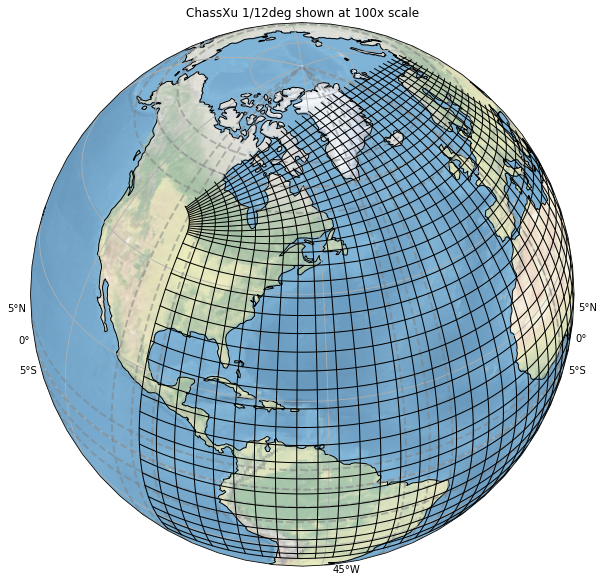

In [3]:
plotgrid(grid=grid, plotStep=100, lat0=40, lon0=-65, title="ChassXu 1/12deg shown at 100x scale")

Text(0.5, 1.0, 'NA12')

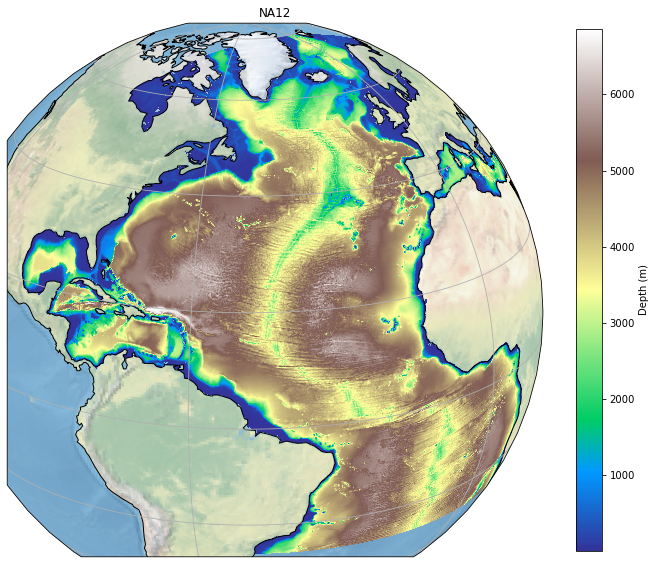

In [4]:
import cartopy.crs as crs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
url = 'http://map1c.vis.earthdata.nasa.gov/wmts-geo/wmts.cgi'
layer = 'BlueMarble_NextGeneration'

topo = xr.open_dataset("/Users/james/Documents/Github/esm_lab/grid_gen/gridInfo/chassxu/09m11/depth_ATLb0.08_09m11_mom6.nc")
topo.depth.values = topo.depth.where(topo.depth!=0)
g_coarse = grid.coarsen(nxp=2, nyp=2,boundary="trim").mean()


figure = plt.figure(figsize=(12,12))
ax = figure.add_subplot(1,1,1, projection=crs.NearsidePerspective(central_latitude=20, central_longitude=-50))
ax.set_extent([-100, 30, -60,90], crs=crs.PlateCarree())
im = ax.pcolormesh(g_coarse.x.values, g_coarse.y.values, topo.depth.values, transform=crs.PlateCarree(), cmap='terrain')
ax.add_wmts(url, 'BlueMarble_NextGeneration')
plt.colorbar(im, label="Depth (m)", shrink=0.8)
ax.stock_img()
ax.coastlines()
ax.gridlines()
plt.title("NA12")


Text(0.5, 1.0, 'NA12')

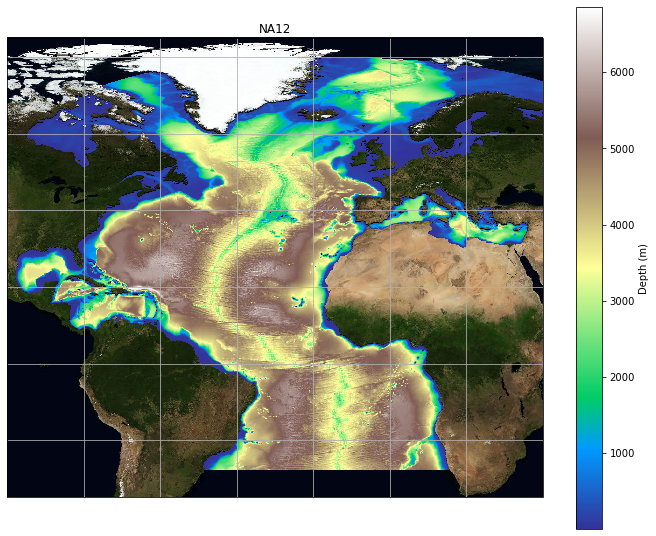

In [5]:


figure = plt.figure(figsize=(12,12))
ax = figure.add_subplot(1,1,1, projection=crs.PlateCarree())
ax.add_wmts(url, layer)
ax.set_extent([-100, 40, -35,85], crs=crs.PlateCarree())
im = ax.pcolormesh(g_coarse.x.values, g_coarse.y.values, topo.depth.values, transform=crs.PlateCarree(), cmap='terrain')
ax.add_wmts(url, 'BlueMarble_NextGeneration')
plt.colorbar(im, label="Depth (m)", shrink=0.8)
ax.gridlines()
plt.title("NA12")


# Use Index Selection to create subgrid for Regular Grid

Note that hte dataset read in above is the 1/12th supergrid. So, while it shows 1/25th degree resolution, MOM6 only solves equations for regular grid resolution (i.e., 1/12th or bathymetry read in below.) Therefore, we need to enhance our resolution using xarray interpolate which is built using scipy interpolate.

In [6]:
## ideally I would use find nearest to find the indice closest to a particular value, but because this is an irregular mesh 2d grid it doesn't work as intended
#latMinInd = find_nearest(array = grid['y'].values, value = 45)
#latMaxInd = find_nearest(array = grid['y'].values, value = 50)
#lonMinInd = find_nearest(array = grid['x'].values, value = -80)
#lonMaxInd = find_nearest(array = grid['x'].values, value = -70)

In [7]:
# v1 - southern boundary at 5 South
#latMinInd = 600
#latMaxInd = 2550
#lonMinInd = 0
#lonMaxInd = 1550


# v2 - southern boundary at 5 North - this looks like the winner
latMinInd = 860
latMaxInd = 2550
lonMinInd = 0
lonMaxInd = 1550

# test v3 - just exploring grid sizing to include lab sea
#latMinInd = 860
#latMaxInd = 3100
#lonMinInd = 0
#lonMaxInd = 1550

# test v4 - exploring grid sizing to include Baffin Bay
#latMinInd = 730
#latMaxInd = 3800
#lonMinInd = 0
#lonMaxInd = 1550

# test v5 - full north atlantic
#latMinInd = 730
#latMaxInd = 3800
#lonMinInd = 0
#lonMaxInd = 2500

#### Slice down our parent grid to our boundary

In [8]:
subgrid = grid.isel(nyp=slice(latMinInd, latMaxInd+1), nxp=slice(lonMinInd,lonMaxInd+1), ny=slice(latMinInd, latMaxInd), nx=slice(lonMinInd,lonMaxInd))
#subgrid

<GeoAxesSubplot:title={'center':'NWA12 Subgrid'}>

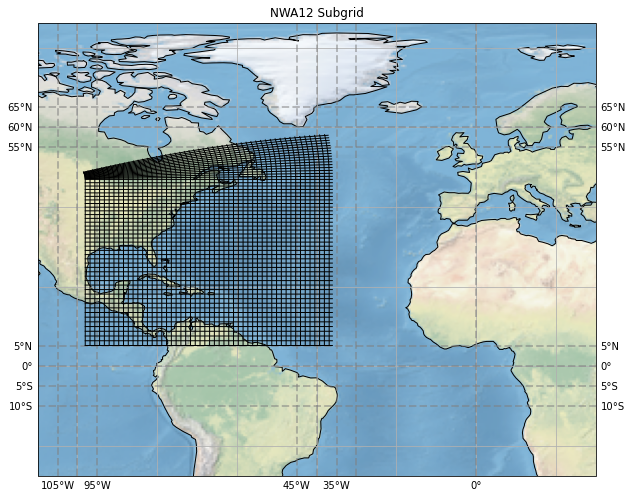

In [9]:
plotgrid(grid=subgrid, plotStep=30, plotproj='platecarree',mapExtent=[-110, 30, -10,80], title="NWA12 Subgrid")

#### Make sure there are no NaNs


In [10]:
np.count_nonzero(np.isnan(subgrid.x.values))

0

In [11]:
# save the netcdf file
subgrid.to_netcdf("/Users/james/Downloads/nwa12_interped.nc", format='NETCDF3_64BIT')

In [12]:
test = xr.open_dataset("/Users/james/Downloads/nwa12_interped.nc")
test

<xarray.Dataset>
Dimensions:   (nx: 1550, nxp: 1551, ny: 1690, nyp: 1691)
Dimensions without coordinates: nx, nxp, ny, nyp
Data variables:
    x         (nyp, nxp) float64 ...
    y         (nyp, nxp) float64 ...
    angle_dx  (nyp, nxp) float64 ...
    dx        (nyp, nx) float64 ...
    dy        (ny, nxp) float64 ...
    area      (ny, nx) float64 ...
    tile      |S255 ...
Attributes:
    history:  grid_hycom2mom6

<GeoAxesSubplot:title={'center':'NWA12 - 1550 x 1690 Supergrid'}>

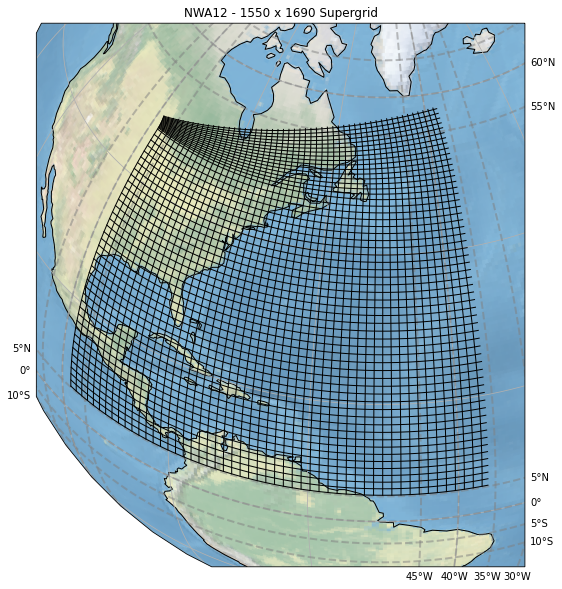

In [13]:
plotgrid(grid=test, plotStep=30, mapExtent=[-110, -30, -10,60], title = "NWA12 - 1550 x 1690 Supergrid")

# What percentage of the grid is land?

In [14]:
land = xr.open_dataset("/Users/james/Documents/Github/esm_lab/grid_gen/gridInfo/chassxu/09m11/land_mask.nc")
subland = land.isel(ny=slice(int(latMinInd/2), int(latMaxInd/2)), nx=slice(int(lonMinInd/2),int(lonMaxInd/2)))

# 1 is land, 0 is ocean
unique, counts = np.unique(subland.mask, return_counts=True)
print(unique,counts)

[0. 1.] [393276 261599]


In [15]:
print("{0:.00%}".format(counts[1] / ( counts[1] +counts[0])))

40%


# Load Bathymetry and Interpolate

In [16]:
topo = xr.open_dataset("/Users/james/Documents/Github/esm_lab/grid_gen/gridInfo/chassxu/09m11/depth_ATLb0.08_09m11_mom6.nc")
#topo

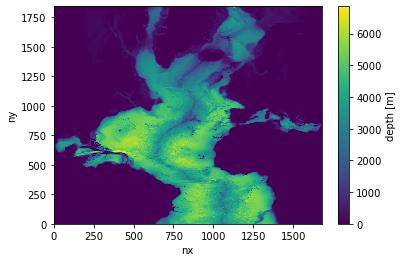

In [17]:
topo.depth.plot()

In [18]:
subtopo = topo.isel(ny=slice(int(latMinInd/2), int(latMaxInd/2)), nx=slice(int(lonMinInd/2),int(lonMaxInd/2)))
#subtopo

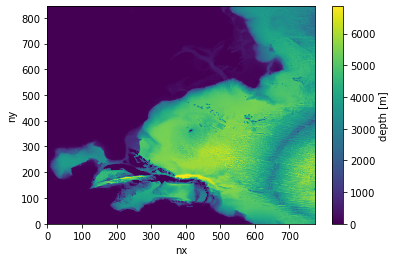

In [19]:
subtopo.depth.plot()

In [20]:
print(np.count_nonzero(np.isnan(subtopo.depth.values)))

0


In [21]:
# Mask Out Hudson Bay
hudson = subtopo
for y in range(1500,len(hudson.ny)):
    for x in range(400,600):
        if y > 1500 and x < 600:
            hudson.depth[y,x] = 0.0


In [22]:
subtopo = hudson.copy()

Text(0.5, 1.0, 'NWA12 Bathymetry - 775x845')

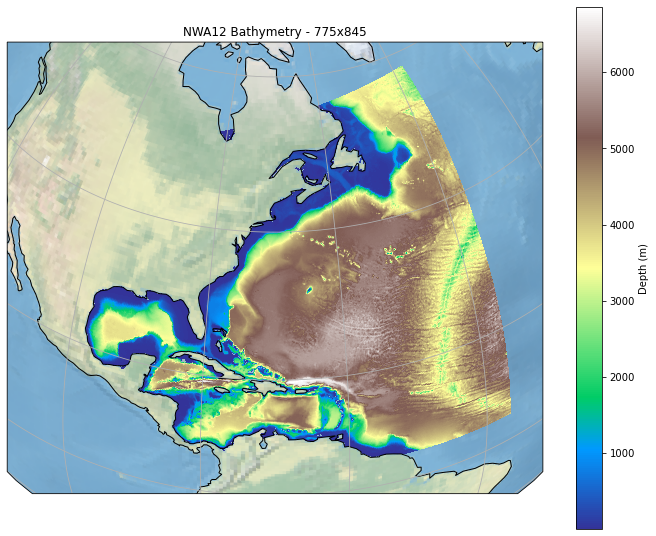

In [25]:
sg = subgrid.coarsen(nxp=2, nyp=2,boundary="trim").mean()

#subtopo_interp.depth.values = subtopo_interp.depth.where(subtopo_interp['depth'].values > 0.01,np.nan)
import cartopy.crs as crs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
#subtopo.depth.values = subtopo.depth.where(subtopo.depth!=0)

figure = plt.figure(figsize=(12,12))
ax = figure.add_subplot(1,1,1, projection=crs.NearsidePerspective(central_latitude=45, central_longitude=290))
ax.set_extent([-110, -30, 0,60], crs=crs.PlateCarree())
im = ax.pcolormesh(sg.x.values, sg.y.values, subtopo.depth.where(subtopo['depth'].values > 0.01,np.nan), transform=crs.PlateCarree(), cmap='terrain')
plt.colorbar(im, label="Depth (m)", shrink=0.8)
ax.stock_img()
ax.coastlines()
ax.gridlines()
plt.title("NWA12 Bathymetry - 775x845")

Text(0.5, 1.0, 'NWA12 Bathymetry - 775x845')

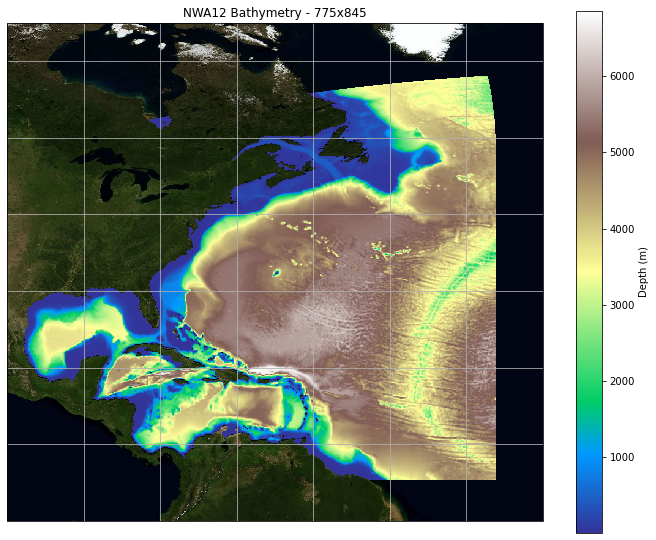

In [28]:
figure = plt.figure(figsize=(12,12))
ax = figure.add_subplot(1,1,1, projection=crs.PlateCarree())
ax.add_wmts(url, layer)
ax.set_extent([-100, -30, 0,65], crs=crs.PlateCarree())
im = ax.pcolormesh(sg.x.values, sg.y.values, subtopo.depth.where(subtopo['depth'].values > 0.01,np.nan), transform=crs.PlateCarree(), cmap='terrain')
ax.add_wmts(url, 'BlueMarble_NextGeneration')
plt.colorbar(im, label="Depth (m)", shrink=0.8)
ax.gridlines()
plt.title("NWA12 Bathymetry - 775x845")


# Mosaic Files

These files are necessary for MOM6 information exchange between land/atmos/ocean

In [29]:
import sys, os, logging, cartopy
from gridtools.gridutils import GridUtils

inputDir = "/Users/james/Documents/Github/esm_lab/grid_gen/gridInfo/nwa12/"

# Initialize a grid object
grd = GridUtils()
grd.openGrid("/Users/james/Downloads/nwa12_interped.nc", gridType='MOM6')
grd.readGrid()


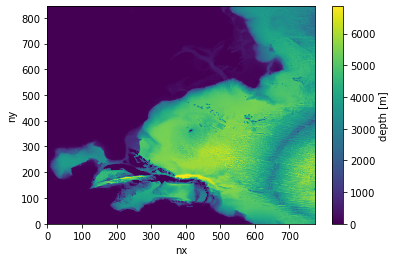

In [30]:
subtopo['depth'].plot()

In [31]:
# Write out FMS related support files
grd.makeSoloMosaic(
    topographyGrid=subtopo['depth'],
    writeLandmask=True,
    writeOceanmask=True,
    inputDirectory=inputDir,
    overwrite=True,
)
grd.saveGrid(filename=os.path.join(inputDir, "ocean_hgrid.nc"))


Successfully wrote netCDF file to /Users/james/Documents/Github/esm_lab/grid_gen/gridInfo/nwa12/ocean_hgrid.nc


# Edit Dtype on Land/Ocean Mask and fill Hudson Bay as land cells

In [32]:
land_mask = xr.open_dataset(inputDir + "land_mask.nc")

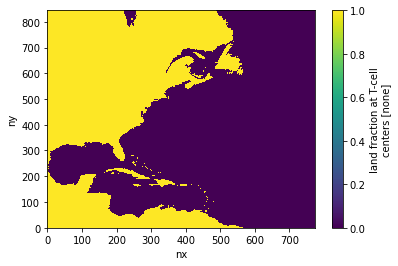

In [33]:
land_mask.mask.plot()

In [34]:
land_mask

<xarray.Dataset>
Dimensions:  (nx: 775, ny: 845)
Dimensions without coordinates: nx, ny
Data variables:
    mask     (ny, nx) int64 ...
    x        (ny, nx) float64 ...
    y        (ny, nx) float64 ...
Attributes:
    grid_version:  0.2
    code_version:  ESMG/gridtools: ['heads/main-0-gea88375397', '']
    history:       2022-01-07: gridtools.grid.mom6.convert_ROMS_to_MOM6 + kwargs

In [35]:
# Mask Out Hudson Bay
hudson = land_mask
for y in range(750,len(hudson.ny)):
    for x in range(200,300):
        if y > 750 and x < 300:
            hudson.mask[y,x] = 1.0

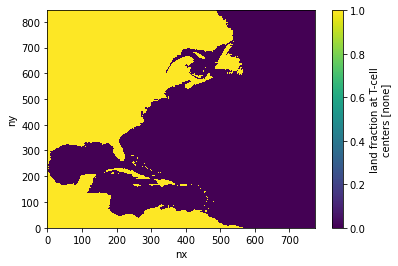

In [36]:
hudson.mask.plot()

In [37]:
hudson.to_netcdf(inputDir + "netcdf3/land_mask.nc", mode='w', format='NETCDF3_64BIT')

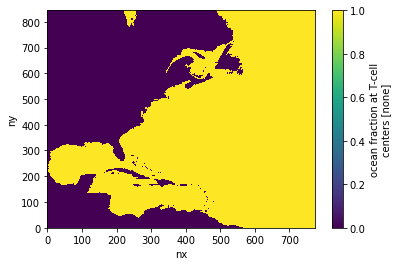

In [38]:
ocean_mask = xr.open_dataset(inputDir + "ocean_mask.nc")
ocean_mask.mask.plot()

In [39]:
# Mask Out Hudson Bay
hudson = ocean_mask
for y in range(750,len(hudson.ny)):
    for x in range(200,300):
        if y > 750 and x < 300:
            hudson.mask[y,x] = 0.0

In [40]:
ocean_mask = hudson.copy()
ocean_mask["mask"] = ocean_mask.mask.astype('double')

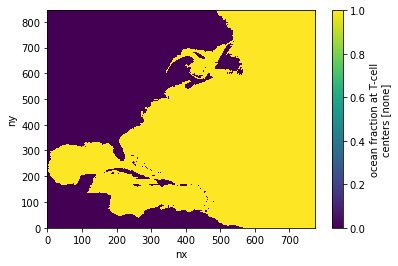

In [41]:
ocean_mask.mask.plot()

In [42]:
ocean_mask.to_netcdf(inputDir + "netcdf3/ocean_mask.nc", mode='w', format='NETCDF3_64BIT')

# Manually convert all files to netcdf3

MOM6 currently takes netcdf3 files - not netcdf4

In [44]:
import xarray as xr
from os import listdir
from os.path import isfile, join
myPath = "/Users/james/Documents/Github/esm_lab/grid_gen/gridInfo/nwa12/"
fileList = [f for f in listdir(myPath) if isfile(join(myPath, f))]
fileList.remove('land_mask.nc')
fileList.remove('ocean_mask.nc')
fileList

['land_mosaic_tile1Xocean_mosaic_tile1.nc',
 'mosaic.nc',
 'atmos_mosaic_tile1Xocean_mosaic_tile1.nc',
 'atmos_mosaic_tile1Xland_mosaic_tile1.nc',
 'ocean_mosaic.nc',
 'ocean_hgrid.nc',
 'ocean_topog.nc']

In [45]:

for f in fileList:
    if f.endswith('.nc'):
        print(f)
        tem = xr.open_dataset(myPath + f)
        tem.to_netcdf(path=str(myPath + 'netcdf3/' + f), format='NETCDF3_CLASSIC')

land_mosaic_tile1Xocean_mosaic_tile1.nc
mosaic.nc
atmos_mosaic_tile1Xocean_mosaic_tile1.nc
atmos_mosaic_tile1Xland_mosaic_tile1.nc
ocean_mosaic.nc
ocean_hgrid.nc
ocean_topog.nc


# Create Rivers File

In [46]:
import xarray as xr
import numpy as np
riv = xr.open_dataset("/Users/james/Documents/Github/esm_lab/grid_gen/gridInfo/chassxu/09m11/rivers_09m11_mom6.nc")
#riv

In [47]:
# v2 - southern boundary at 5 North - this looks like the winner
latMinInd = 860
latMaxInd = 2550
lonMinInd = 0
lonMaxInd = 1550

subriv = riv.isel(Y=slice(int(latMinInd/2), int(latMaxInd/2)), X=slice(int(lonMinInd/2),int(lonMaxInd/2)))
#subriv

In [48]:
subriv.to_netcdf(inputDir + "netcdf3/rivers.nc", mode='w', format='NETCDF3_64BIT')